In [56]:
cd /home/dmoi/projects/foldtree2/

/home/dmoi/projects/foldtree2


In [57]:
import sys
sys.path.append('/home/dmoi/projects/foldtree2')
#read the afdb clusters file
import pandas as pd
import numpy as np
import glob
import os
#autoreload
import pickle
from src import AFDB_tools
import toytree
import tqdm
from matplotlib import pyplot as plt

In [58]:
datadir = '../../datasets/'
encoder_save = 'encoder_lowcost_final'
decoder_save = 'decoder_lowcost_final'

model_dir = 'models/'


outdir_base = '../../results/foldtree2/'

if not os.path.exists(outdir_base):
    os.makedirs(outdir_base)

#output for matrices 
matdir = outdir_base + 'matrices/'
if not os.path.exists(matdir):
    os.makedirs(matdir)

#output for trees
treedir = outdir_base + 'trees/'
if not os.path.exists(treedir):
    os.makedirs(treedir)

In [59]:
#read the afdb rep file
reps = pd.read_table( datadir + 'afdbclusters/1-AFDBClusters-entryId_repId_taxId.tsv', header=None, names=['entryId', 'repId', 'taxId'] )
print( 'reps' , reps.head() )

reps       entryId       repId    taxId
0  A0A009E921  A0A009E921  1310605
1  A0A009F5K6  A0A009E921  1310605
2  A0A009E9H3  A0A009E9H3  1310605
3  A0A484ZLT0  A0A009E9H3    82979
4  A0A009ECR5  A0A009ECR5  1310605


In [60]:
repdirs = '../../datasets/foldtree2/struct_align/'

In [61]:
mkdirs = False
if mkdirs == True:
    #make a structure alignment directory
    if not os.path.exists( 'struct_align' ):
        os.makedirs( 'struct_align' )
    
    #make a directory for each cluster representative
    for rep in reps['repId']:
        if not os.path.exists( datadir +'struct_align/' + rep  ):
            os.makedirs(datadir + 'struct_align/' + rep  )
        if not os.path.exists( datadir+ 'struct_align/' + rep  + '/structs/'):
            os.makedirs( datadir+ 'struct_align/' + rep + '/structs/' )
            

In [62]:
#download n struct members for each cluster
dl_structs = False
if dl_structs == True:
    n = 5
    for rep in tqdm.tqdm(reps.repId.unique() ):
        subdf = reps[ reps['repId'] == rep ]
        if len(subdf) < n:
            n = len(subdf)
        subdf = subdf.sample( n = n  )
        subdf = subdf.head( n )
        #download the structures
        for uniID in subdf['entryId']:
            AFDB_tools.grab_struct(uniID , structfolder=datadir+'struct_align/' + rep  + '/structs/')

In [63]:
#for each folder in struct_align, align the structures with all vs all using foldseek
from src import foldseek2tree
aln_structs = False
if aln_structs == True:
    for rep in tqdm.tqdm(reps.repId.unique() ):
        #align the structures
        foldseek2tree.runFoldseek_allvall_EZsearch( infolder= datadir + 'struct_align/' + rep  + '/structs/', outpath=datadir+'struct_align/' + rep + '/allvall.csv' )


In [64]:
import foldtree2_ecddcd as ft2
import torch
#get all example structures in a directory
structs = glob.glob('families/fsx1/*.pdb')
print(structs)

ndim = 844
converter = ft2.PDB2PyG()
#switch device to cpu
with open( model_dir + encoder_save + 'proto_model.pkl' , 'rb' ) as f:
    encoder,decoder = pickle.load( f )

alphabetsize = encoder.vector_quantizer.embedding_dim
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

#device = torch.device('cpu')
encoder = encoder.to(device)
encoder.eval()

['families/fsx1/fsxA11_monomer.pdb', 'families/fsx1/WP_163487151_Hborinquense.pdb', 'families/fsx1/4GSX.pdb', 'families/fsx1/WP_049937247_Hnatans.pdb', 'families/fsx1/4OJC_model.pdb', 'families/fsx1/4HJ1.pdb', 'families/fsx1/WP_058826362_Haloferax.pdb', 'families/fsx1/6EGU.pdb', 'families/fsx1/WP_007110832_Naltunense.pdb', 'families/fsx1/3n43.pdb', 'families/fsx1/5mf1mono.pdb', 'families/fsx1/1rer.pdb', 'families/fsx1/2ala.pdb', 'families/fsx1/2I69.pdb', 'families/fsx1/1SVB.pdb', 'families/fsx1/6E18.pdb', 'families/fsx1/5ow3.pdb', 'families/fsx1/1OAN.pdb']


/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


HeteroGAE_Encoder(
  (convs): ModuleList(
    (0): ModuleDict(
      (res_backbone_res): MFConv(844, 400)
      (res_backbonerev_res): MFConv(400, 400)
      (res_contactPoints_res): MFConv(400, 400)
      (res_hbond_res): MFConv(400, 400)
    )
    (1-2): 2 x ModuleDict(
      (res_backbone_res): MFConv(400, 400)
      (res_backbonerev_res): MFConv(400, 400)
      (res_contactPoints_res): MFConv(400, 400)
      (res_hbond_res): MFConv(400, 400)
    )
  )
  (bn): BatchNorm1d(844, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.001, inplace=False)
  (out_dense): Sequential(
    (0): Linear(420, 200, bias=True)
    (1): SiLU()
    (2): Linear(200, 200, bias=True)
    (3): SiLU()
    (4): Linear(200, 200, bias=True)
    (5): SiLU()
    (6): Linear(200, 200, bias=True)
    (7): SiLU()
    (8): Linear(200, 200, bias=True)
    (9): SiLU()
    (10): Linear(200, 200, bias=True)
    (11): SiLU()
    (12): Linear(200, 200, bias=True)
    (13): SiLU()
    

In [65]:
import importlib
importlib.reload(ft2)
from torch_geometric.data import DataLoader

struct_dat = ft2.StructureDataset('structs_structalign_new.h5')
#struct_dat = ft2.StructureDataset('structs_training.h5')
encoder_loader = DataLoader(struct_dat, batch_size=1, shuffle=True)

#encode the structures
encoder.eval()
encode_alns = False
if encode_alns == True:
    def databatch2list(loader):
        for data in loader:
            data = data.to_data_list()
            for d in data:
                yield d
    encoder_loader = databatch2list(encoder_loader)
    encoder.encode_structures_fasta(encoder_loader , 'aln_encoded.fasta' )

/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [66]:
encoded_fasta = '/home/dmoi/projects/foldtree2/aln_encoded.fasta' 
seqstr = ''
ID = ''

seqdict = {}
with open(encoded_fasta, 'r') as f:
    #read all chars of file into a string
    for line in tqdm.tqdm(f):
        if line[0] == '>' and line[-1] == '\n':
            seqdict[ID] = seqstr
            ID = line[1:].strip()
            seqstr = ''
        else:
            seqstr += line.strip()
del seqdict['']
encoded_df = pd.DataFrame( seqdict.items() , columns=['protid', 'seq'] )
#change index to protid
encoded_df.index = encoded_df.protid
encoded_df = encoded_df.drop( 'protid', axis=1 )

print(encoded_df)

202807it [00:00, 1552206.89it/s]

                                                          seq
protid                                                       
A0A536K3S3  %%9!@!9!!,\t\t1;,1!"!!\t1:$/9!...
A0A5R9NZB5  036;$\t6\t,1\t,"$\t444</\t,,...
A0A444UFC9  :$$::$:$=/-=$=...
A0A3B8WXP9  #==!=/)0);,01:8)8/\t::)$...
A0A242XS45  304$;")0):8)'8)/811\t/:':...
...                                                       ...
A0A0J0XKA0  :\t:<=<:$/=11=1<=<<...
A0A496P344  $8\t\t????!==8/$/,,$...
A0A2P6TGU9  $"11,1\t""3\t44:\t))$'...
A0A0G2ZCU5  3$6\t/:6137$/11\t7666".4$\...
A0A1I5FF76  ::::+1$>$)):1\t1\t$1116>>2...

[12934 rows x 1 columns]


In [67]:
charset = 249
#make fasta is shifted by 1 and goes from 1-248 included
#0x01 – 0xFF excluding > (0x3E), = (0x3D), < (0x3C), - (0x2D), Space (0x20), Carriage Return (0x0d) and Line Feed (0x0a)
#replace 0x22 or " which is necesary for nexus files and 0x23 or # which is also necesary

replace_dict = {chr(0):chr(246) , '"':chr(248) , '#':chr(247), '>' : chr(249), '=' : chr(250), '<' : chr(251), '-' : chr(252), ' ' : chr(253) , '\r' : chr(254), '\n' : chr(255) }
rev_replace_dict = { v:k for k,v in replace_dict.items() }

replace_dict_ord = { ord(k):ord(v) for k,v in replace_dict.items() }
rev_replace_dict_ord = { ord(v):ord(k) for k,v in replace_dict.items() }

print(replace_dict)
print(rev_replace_dict)

print( replace_dict_ord )

print(rev_replace_dict_ord)

{'\x00': 'ö', '"': 'ø', '#': '÷', '>': 'ù', '=': 'ú', '<': 'û', '-': 'ü', ' ': 'ý', '\r': 'þ', '\n': 'ÿ'}
{'ö': '\x00', 'ø': '"', '÷': '#', 'ù': '>', 'ú': '=', 'û': '<', 'ü': '-', 'ý': ' ', 'þ': '\r', 'ÿ': '\n'}
{0: 246, 34: 248, 35: 247, 62: 249, 61: 250, 60: 251, 45: 252, 32: 253, 13: 254, 10: 255}
{246: 0, 248: 34, 247: 35, 249: 62, 250: 61, 251: 60, 252: 45, 253: 32, 254: 13, 255: 10}


In [68]:
encoded_df.seq = encoded_df.seq.map(lambda x : ''.join([ c if c not in replace_dict else replace_dict[c] for c in x]))
print(encoded_df)

                                                          seq
protid                                                       
A0A536K3S3  %%9!@!9!!,\t\t1;,1!ø!!\t1:$/9!...
A0A5R9NZB5  036;$\t6\t,1\t,ø$\t444û/\t,,...
A0A444UFC9  :$$::$:$ú/üú$ú...
A0A3B8WXP9  ÷úú!ú/)0);,01:8)8/\t::)$...
A0A242XS45  304$;ø)0):8)'8)/811\t/:':...
...                                                       ...
A0A0J0XKA0  :\t:ûúû:$/ú11ú1ûúûû...
A0A496P344  $8\t\t????!úú8/$/,,$...
A0A2P6TGU9  $ø11,1\tøø3\t44:\t))$'...
A0A0G2ZCU5  3$6\t/:6137$/11\t7666ø.4$\...
A0A1I5FF76  ::::+1$ù$)):1\t1\t$1116ùù2...

[12934 rows x 1 columns]


In [69]:
#embedding starts at 0
encoded_df['ord'] = encoded_df.seq.map( lambda x: [ ord(c) for c in x] )
#hex starts at 1
encoded_df['hex2'] = encoded_df.ord.map( lambda x: [ hex(c) for c in x] )
print(encoded_df.head())

                                                          seq  \
protid                                                          
A0A536K3S3  %%9!@!9!!,\t\t1;,1!ø!!\t1:$/9!...   
A0A5R9NZB5  036;$\t6\t,1\t,ø$\t444û/\t,,...   
A0A444UFC9  :$$::$:$ú/üú$ú...   
A0A3B8WXP9  ÷úú!ú/)0);,01:8)8/\t::)$...   
A0A242XS45  304$;ø)0):8)'8)/811\t/:':...   

                                                          ord  \
protid                                                          
A0A536K3S3  [37, 37, 16, 57, 26, 33, 64, 26, 33, 57, 33, 2...   
A0A5R9NZB5  [48, 51, 54, 59, 27, 16, 36, 27, 9, 25, 26, 54...   
A0A444UFC9  [15, 15, 5, 15, 58, 3, 36, 36, 29, 19, 19, 58,...   
A0A3B8WXP9  [17, 17, 5, 28, 247, 28, 250, 250, 33, 5, 250,...   
A0A242XS45  [51, 48, 3, 52, 36, 59, 248, 24, 6, 26, 41, 48...   

                                                         hex2  
protid                  

In [70]:
from torch_geometric.data import HeteroData
import torch_geometric
import torch
torch.autograd.set_detect_anomaly(True)


from scipy import sparse

converter = ft2.PDB2PyG()


In [85]:
import py3Dmol

def view_custom_pdb(pdb_file, chain='A'):
    """
    Visualize a PDB structure from a file, highlight a specific residue with thicker sticks,
    show the backbone for the selected residue, and add an arrow-like indicator.
    
    Parameters:
    - pdb_file: str, path to the local PDB file.
    - residue_num: int, residue number to highlight.
    - chain: str, the chain identifier (default 'A').
    """
    # Read the PDB file content
    with open(pdb_file, 'r') as f:
        pdb_content = f.read()

    # Initialize py3Dmol viewer
    viewer = py3Dmol.view(width=800, height=600)
    
    # Add the PDB structure to the viewer
    viewer.addModel(pdb_content, 'pdb')
    
    # Apply cartoon style for the overall structure
    viewer.setStyle({'cartoon': {'color': 'cyan'}})
    
    
    # Add molecular surface for the rest of the structure
    viewer.addSurface(py3Dmol.VDW, {'opacity': 0.5})
    
    
    # Set zoom and background color
    viewer.zoomTo()
    viewer.setBackgroundColor('white')
    
    # Show the structure
    return viewer.show()



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

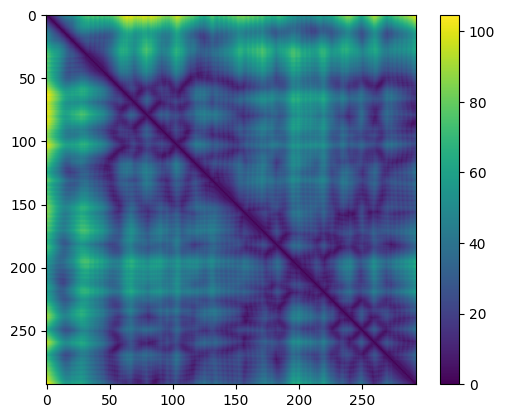

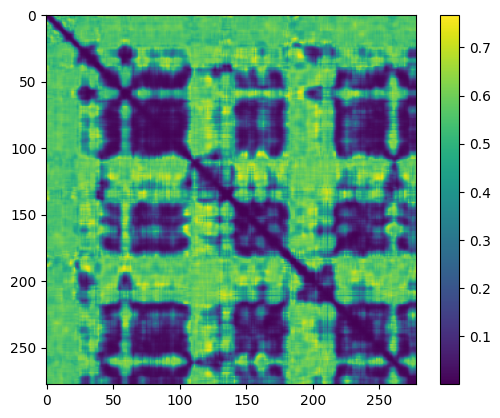

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

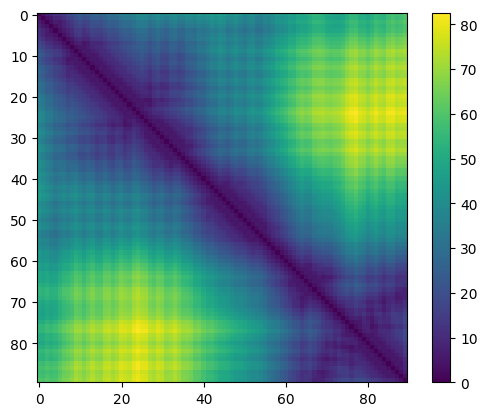

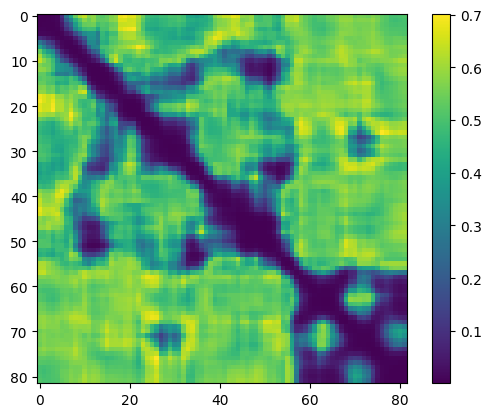

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

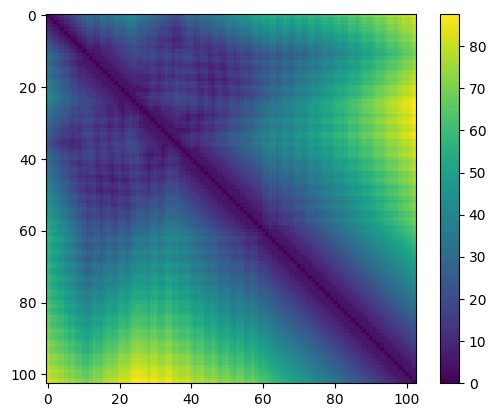

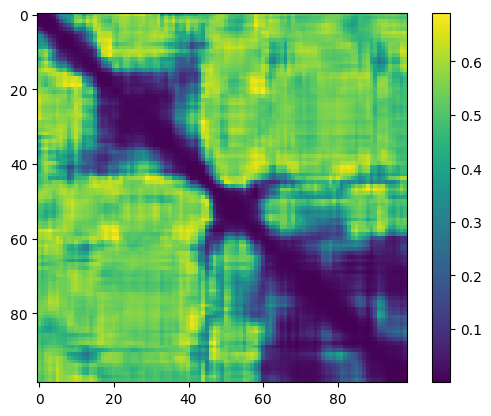

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

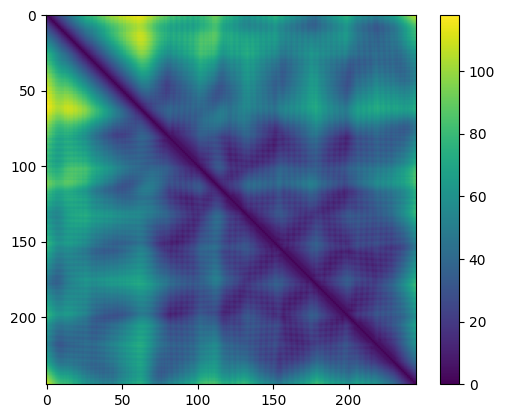

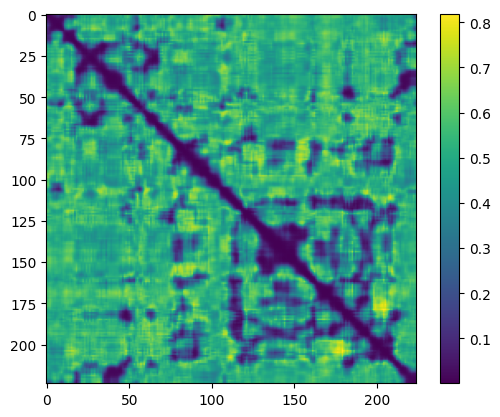

In [86]:

from Bio.PDB import PDBParser

def get_alpha_carbon_distance_matrix(pdb_file):
    """
    Extracts the alpha carbon (Cα) atoms from a PDB structure
    and computes the distance matrix in numpy format.

    Parameters:
    pdb_file (str): Path to the PDB file.

    Returns:
    numpy.ndarray: A matrix of distances between all Cα atoms.
    """
    # Initialize the PDB parser
    parser = PDBParser(QUIET=True)
    
    # Parse the structure
    structure = parser.get_structure('structure', pdb_file)
    
    # Extract alpha carbon (Cα) atoms
    ca_atoms = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if 'CA' in residue:
                    ca_atoms.append(residue['CA'])
    
    # Get the number of Cα atoms
    num_atoms = len(ca_atoms)
    
    # Initialize the distance matrix
    dist_matrix = np.zeros((num_atoms, num_atoms))
    
    # Compute the distances between all pairs of Cα atoms
    for i, atom_i in enumerate(ca_atoms):
        for j, atom_j in enumerate(ca_atoms):
            dist_matrix[i, j] = atom_i - atom_j
    
    return dist_matrix


#get aa and contacts
def get_backbone(naa):
    backbone_mat = np.zeros((naa, naa))
    backbone_rev_mat = np.zeros((naa, naa))
    np.fill_diagonal(backbone_mat[1:], 1)
    np.fill_diagonal(backbone_rev_mat[:, 1:], 1)
    return backbone_mat, backbone_rev_mat

def sparse2pairs(sparsemat):
    sparsemat = sparse.find(sparsemat)
    return np.vstack([sparsemat[0],sparsemat[1]])

def decoder_reconstruction2aa( ords , device, verbose = False):
    encoder.eval()
    decoder.eval()
    z = encoder.vector_quantizer.embeddings( ords  )
    edge_index = torch.tensor( [ [i,j] for i in range(z.shape[0]) for j in range(z.shape[0]) ]  , dtype = torch.long).T
    #generate a backbone for the decoder
    data = HeteroData()
    backbone, backbone_rev = get_backbone( z.shape[0] )
    backbone = sparse.csr_matrix(backbone)
    backbone_rev = sparse.csr_matrix(backbone_rev)
    backbone = sparse2pairs(backbone)
    backbone_rev = sparse2pairs(backbone_rev)
    positional_encoding = converter.get_positional_encoding( z.shape[0] , 256 )
    
    data['positions'].x = torch.tensor( positional_encoding, dtype=torch.float32)
    data['res','backbone','res'].edge_index = torch.tensor(backbone,  dtype=torch.long )
    
    #change to bidirectional
    data['res','backbonerev','res'].edge_index = torch.tensor(backbone_rev,  dtype=torch.long )
    data['res','backbone','res'].edge_index = torch_geometric.utils.add_self_loops(data['res','backbone','res'].edge_index)[0]
    data['res','backbone', 'res'].edge_index =torch_geometric.utils.to_undirected(  data['res','backbone', 'res'].edge_index )

    print(data)

    edge_index = edge_index.to( device )
    data = data.to( device )

    #z = torch.cat([z, data['positions'].x], dim=1)
    #decode_out = decoder(z , data.edge_index_dict[( 'res','contactPoints','res')] , data.edge_index_dict , poslossmod = 1 , neglossmod= 1 )
    recon_x, edge_probs = decoder(z , edge_index , data.edge_index_dict )
    amino_map = decoder.amino_acid_indices
    revmap_aa = { v:k for k,v in amino_map.items() }
    
    edge_probs = edge_probs.reshape((z.shape[0], z.shape[0]))
    if verbose == True:
        print( recon_x )
        print( edge_probs )
    aastr = ''.join(revmap_aa[int(idx.item())] for idx in recon_x.argmax(dim=1) )
    return aastr ,edge_probs



for ex in [4900 , 1000 , 2506 , 103 ]:
    os.makedirs('tmp', exist_ok=True)
    example = encoded_df.iloc[ex]
    protid = encoded_df.index[ex]
    ords = example['ord']
    print( str(protid))
    AFDB_tools.grab_struct(str(protid) , structfolder='tmp/')
    #show struct

    view_custom_pdb('tmp/' + protid + '.pdb', chain='A')

    #get alpha carbon distmat with biopython
    s = get_alpha_carbon_distance_matrix( 'tmp/' + protid + '.pdb')
    plt.imshow(s)
    plt.colorbar()
    plt.show()
    #these are the embedding indices. shift by 1 to get the hex indices
    ords = torch.tensor([ c-1 if c not in rev_replace_dict_ord else rev_replace_dict_ord[c]-1 for c in ords] , dtype=torch.long)
    ords = ords.to(device)

    aa, edgeprobs = decoder_reconstruction2aa( ords , device = device, verbose = True)
    print(aa)
    plt.imshow(1-edgeprobs.detach().cpu().numpy())  
    plt.colorbar()
    plt.show()

    #calculate the distance matrix from the pdb



In [80]:
print( encoded_df)

In [55]:
#find union of all sets of characters for sequences
char_set = set()
for seq in encoded_df.seq:
    char_set = char_set.union( set( seq ) )
char_set = list( char_set )
char_set.sort()
print( char_set )
print( len(char_set) )
ordset = set( [ ord(c) for c in char_set ] )    
print( ordset )

['\x01', '\x02', '\x03', '\x04', '\x05', '\x06', '\x07', '\x08', '\t', '\x0b', '\x0c', '\x0e', '\x0f', '\x10', '\x11', '\x12', '\x13', '\x14', '\x15', '\x16', '\x17', '\x18', '\x19', '\x1a', '\x1b', '\x1c', '\x1d', '\x1e', '\x1f', '!', '$', '%', '&', "'", '(', ')', '*', '+', ',', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '@', '÷', 'ø', 'ù', 'ú', 'û', 'ü', 'ý']
62
{1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 247, 248, 249, 250, 251, 252, 253}


In [258]:
cols = 'query,target,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qaln,taln'.split(',')
alnfiles = glob.glob(datadir + 'struct_align/*/allvall.csv')
fident_thresh = .3
submat =  np.zeros((256,256))
background_freq = np.zeros(len(char_set))
q_mat = np.zeros((256,256))
seqcount = 0

for rep in tqdm.tqdm(alnfiles ):
    q_mat_chunk = np.zeros((256,256))
    submat_chunk = np.zeros((256,256))
    alncount = 0
    #load the all vs all aln
    aln_df = pd.read_table(rep)
    aln_df.columns = cols
    #load the embedding of the structures
    q = aln_df['query'].unique()
    t = aln_df['target'].unique()
    
    seqset = set()
    representative = rep.split('/')[-2]
    for q in aln_df['query'].unique():
        for t in aln_df['target'].unique():
            if q != t:
                #align the structures
                aln = aln_df[ (aln_df['query'] == q) & (aln_df['target'] == t) ]
                if len(aln)> 0 and aln.fident.iloc[0] < fident_thresh:
                    aln = aln.iloc[0]
                    qaln = aln.qaln
                    taln = aln.taln
                    qaccession = q.split( '.' )[0]
                    taccession = t.split( '.' )[0]

                    if qaccession in encoded_df.index and taccession in encoded_df.index:
                        qz = str(encoded_df.loc[qaccession].seq[aln.qstart-1:aln.qend])
                        tz = str(encoded_df.loc[taccession].seq[aln.tstart-1:aln.tend])

                        if qaccession not in seqset:
                            background_freq += np.array([ qz.count( c ) for c in char_set ])
                            seqset.add( qaccession )
                            seqcount += len(qz)
                        
                        if len( qz) == len( qaln.replace('-','') ) and len( tz) == len( taln.replace('-','') ):
                            qz = iter(qz)
                            tz = iter(tz)

                            #transfer the alignments to the embeddings                    
                            qaln_ft2, taln_ft2 = [], []

                            for q_char in qaln:
                                if q_char == '-':
                                    qaln_ft2.append(None)
                                else:
                                    qaln_ft2.append(ord(next(qz)))
                                   
                            for t_char in taln.strip():
                                if t_char == '-':
                                    taln_ft2.append(None)
                                else:
                                    taln_ft2.append(ord(next(tz)))

                            alnzip = list(zip( qaln_ft2 , taln_ft2 ))
                            alnzip = np.array([ [a[0] , a[1]] for a in alnzip if a[0] is not None and a[1] is not None])
                            #normalize by size of alignment
                            
                            submat_chunk[alnzip[:,0] , alnzip[:,1]] += 1
                            #normalize by size of alignment and number of pairs
                            alncount += 1
                            q_mat_chunk[alnzip[:,0] , alnzip[:,1]] += 1 / len(qaln.replace('-',''))
        if alncount > 0:
            submat += (submat_chunk / alncount)

100%|█████████████████████████████████████| 3691/3691 [00:44<00:00, 82.46it/s]


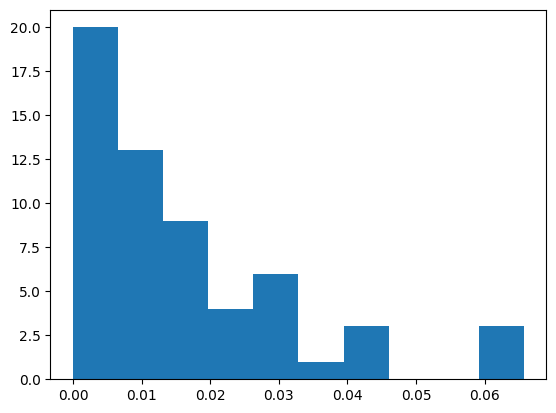

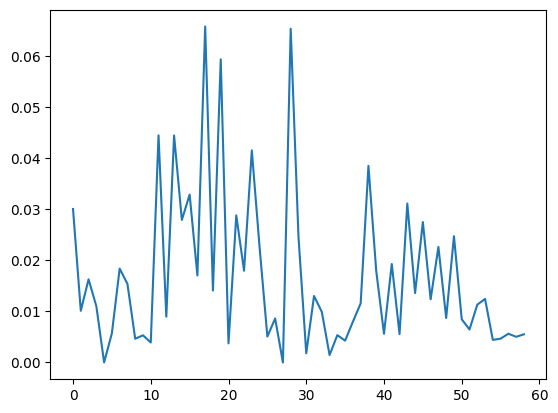

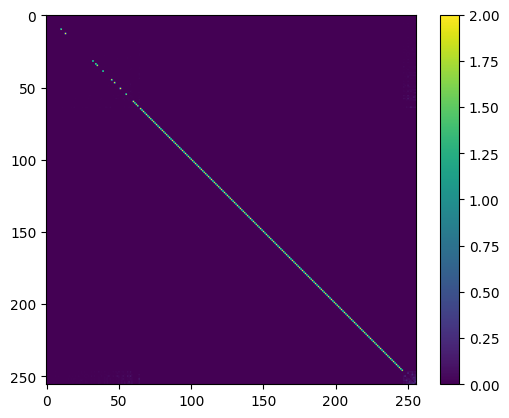

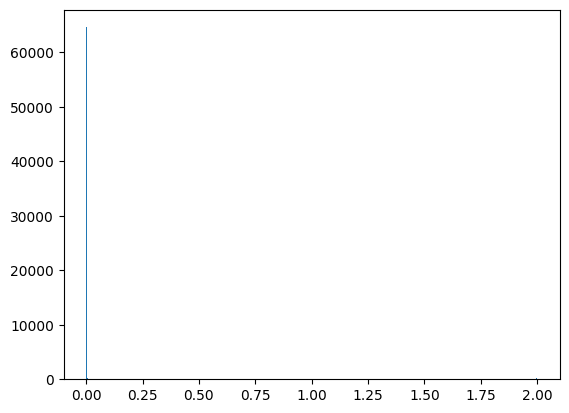

In [274]:
background_freq = background_freq / np.sum( background_freq )
submat = submat + submat.T
plt.hist( background_freq )
plt.show()
plt.plot( background_freq )
plt.show()

#ploT QMAT
plt.imshow(submat)
plt.colorbar()
plt.show()
plt.hist(submat.flatten() , bins = 400)
plt.show()


In [282]:
ords = np.array([ ord(c) for c in char_set ])
ords_original = ords.copy()
ords_original = sorted([ i if i not in rev_replace_dict_ord else rev_replace_dict_ord[i] for i in ords ])

print(ords)
print( ords_original)


[  1   2   3   4   5   6   7   8   9  11  12  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  33  36  37  38  40  41  42
  43  44  46  48  49  50  52  53  54  56  57  58  59  64 247 248 249 250
 251 252 253 254 255]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 64]


['\x01', '\x02', '\x03', '\x04', '\x05', '\x06', '\x07', '\x08', '\t', '\x0b', '\x0c', '\x0e', '\x0f', '\x10', '\x11', '\x12', '\x13', '\x14', '\x15', '\x16', '\x17', '\x18', '\x19', '\x1a', '\x1b', '\x1c', '\x1d', '\x1e', '\x1f', '!', '$', '%', '&', '(', ')', '*', '+', ',', '.', '0', '1', '2', '4', '5', '6', '8', '9', ':', ';', '@', '÷', 'ø', 'ù', 'ú', 'û', 'ü', 'ý', 'þ', 'ÿ']
[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 36, 37, 38, 40, 41, 42, 43, 44, 46, 48, 49, 50, 52, 53, 54, 56, 57, 58, 59, 64, 247, 248, 249, 250, 251, 252, 253, 254, 255]


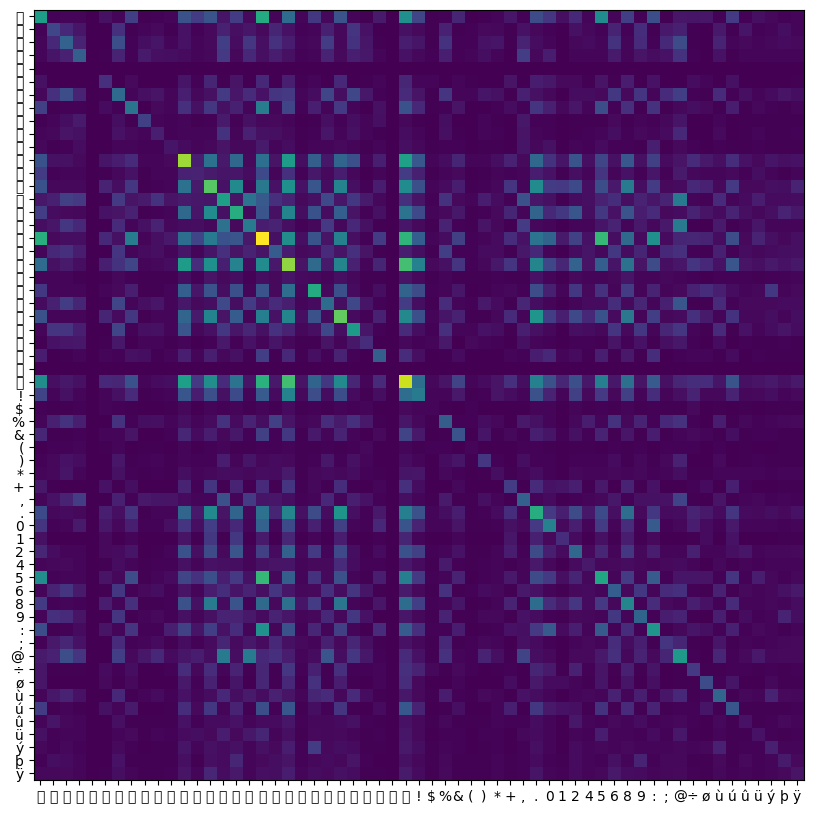

In [285]:
print( char_set)
print( [ ord(c) for c in char_set ] )
alphabet = [ord(c) for c in char_set]
mafft_mat = submat[alphabet,:]
mafft_mat = mafft_mat[:,alphabet]
#set the tick marks to the alphabet
plt.figure( figsize=(10,10))
plt.xticks( range(len(char_set)), char_set)
plt.yticks( range(len(char_set)), char_set )
plt.imshow(mafft_mat)

count_mat = copy.deepcopy(mafft_mat)

In [ ]:
import numpy as np
import math

# Initialize frequency matrix and total count
total_pairs = np.sum(mafft_mat)
# Calculate observed frequencies q_ij
mafft_mat = mafft_mat / total_pairs

# Calculate amino acid frequencies p_i
p_vector = np.sum(mafft_mat, axis=0)

# Calculate expected frequencies e_ij = p_i * p_j
e_matrix = np.outer(p_vector, p_vector)

# Calculate log-odds scores S_ij = log2(q_ij / e_ij)
# Note: We add a small constant to avoid division by zero
log_odds_matrix = np.log2((mafft_mat + 1e-10) / (e_matrix + 1e-10))

# Scaling the log-odds scores (optional, here multiplied by 2 and rounded)
scaled_log_odds_matrix = np.round(log_odds_matrix * 2)
# Print the BLOSUM matrix
print("BLOSUM-like Matrix:")
print(scaled_log_odds_matrix)



['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^']


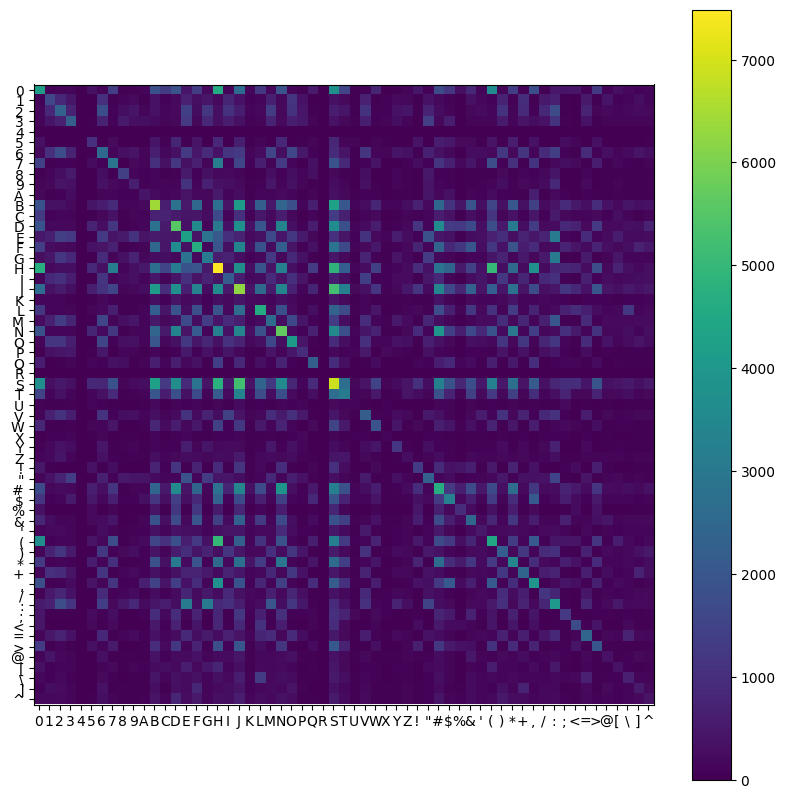

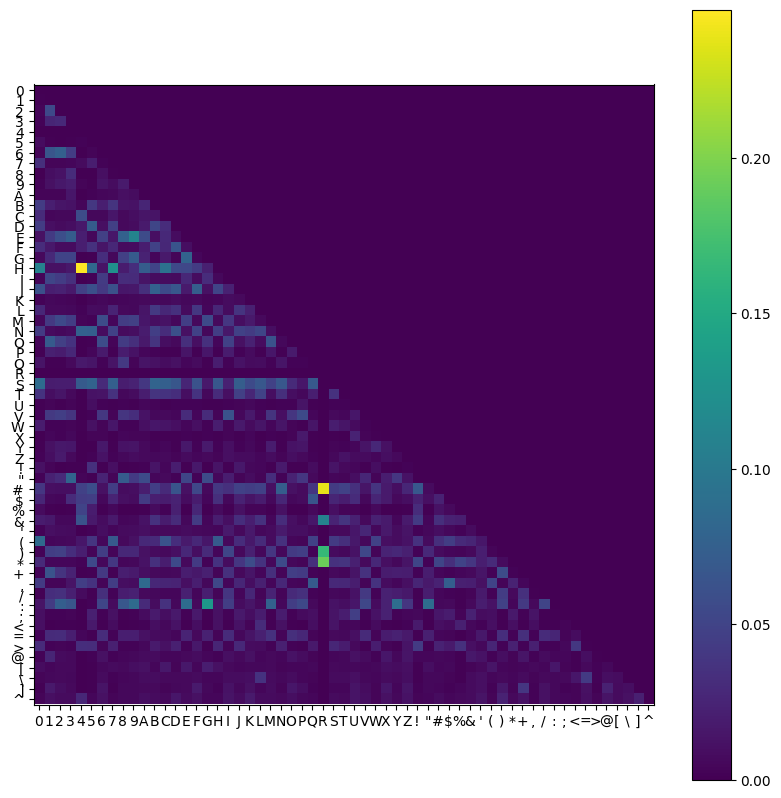

In [348]:
#raxml mat
import copy
inputchars = """0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W X Y Z ! " # $ % & ' ( ) * + , / : ; < = > @ [ \ ] ^ _ { | } ~""".split()

revmap_raxml = { c:ords[i] for i,c in enumerate(inputchars[:len(char_set)]) }
map_raxml = { ords[i]:c for i,c in enumerate(inputchars[:len(char_set)]) }
raxml_alphabet = inputchars[:len(char_set)]
print( raxml_alphabet ) 

q_mat = copy.deepcopy(vismat)

original = copy.deepcopy(vismat)
np.fill_diagonal(original, 0 )


q_mat = q_mat + q_mat.T
alphabet = [ord(c) for c in char_set]
vismat = submat[alphabet, : ]
vismat = vismat[ :, alphabet ]
plt.figure( figsize=(10,10))
plt.imshow(vismat  ) 
#set the tick marks to the alphabet
plt.xticks( range(len(alphabet)), raxml_alphabet)
plt.yticks( range(len(alphabet)), raxml_alphabet )
plt.colorbar()


In [ ]:
import numpy as np
# Initialize count matrix
count_matrix = count_mat

# Calculate total counts for each row
row_sums = np.sum(count_matrix, axis=1)

# Initialize Q-matrix
q_matrix = np.zeros_like(count_matrix)

# Fill the Q-matrix with normalized rates
for i in range(len(amino_acids)):
    for j in range(len(amino_acids)):
        if i != j:
            q_matrix[i][j] = count_matrix[i][j] / row_sums[i]

# Set diagonal elements so that each row sums to zero
for i in range(len(amino_acids)):
    q_matrix[i][i] = -np.sum(q_matrix[i])

# Print the Q-matrix
print("Q-matrix:")
print(q_matrix)


In [ ]:

#normalize qmat so that each column sums to 1
q_mat = np.copy( vismat )
np.fill_diagonal(q_mat, 0 )

for i in range(q_mat.shape[0]):
    q_mat[:,i] = original[:,i] / np.sum( original[:,i] )

#zero out upper triangle
for i in range(q_mat.shape[0]):
    for j in range(i+1, q_mat.shape[1]):
        q_mat[i,j] = 0

plt.figure( figsize=(10,10))
plt.imshow(q_mat   ) 
#set the tick marks to the alphabet
plt.xticks( range(len(alphabet)), raxml_alphabet)
plt.yticks( range(len(alphabet)), raxml_alphabet )
plt.colorbar()



In [366]:
#mafft matrix file example max 248 char

"""
0x01 0x01 2   # (comment)
0x1e 0x1e 2
0x1f 0x1f 2
0x21 0x21 2   # ! × !
0x41 0x41 2   # A × A
0x42 0x42 2   # B × B
0x43 0x43 2   # C × C
"""

def formathex(hexnum):
    if len(hexnum) == 3:
        return hexnum[0:2] + '0' + hexnum[2]
    else:
        return hexnum

def output_mafft_matrix( submat , char_set ,  outpath='mafft_submat.mtx' ):
    print( submat.shape , len( char_set ) )
    with open(outpath, 'w') as f:
        for i in range(len(char_set)):
            for j in range(len(char_set)):
                if i <= j:
                    stringi = char_set[i]
                    stringj = char_set[j]
                    
                    if stringi in replace_dict.keys():
                        stringi = replace_dict[stringi]
                    if stringj in replace_dict.keys():
                        stringj = replace_dict[stringj]
                  
                    hexi = formathex(hex(ord(stringi)))
                    hexj = formathex(hex( ord(stringj)))
                    
                    f.write( f'{hexi} {hexj} {submat[i,j]} \n ')# '+ stringi + 'x' + stringj + ' \n' )
                   
output_mafft_matrix( scaled_log_odds_matrix , char_set= char_set,  outpath='mafft_submat.mtx' )


(59, 59) 59


In [367]:
#preview a few line of the mafft matrix
with open('mafft_submat.mtx', 'r') as f:
    for i in range(10):
        print( f.readline() )


0x01 0x01 4177.940064852555 

 0x01 0x02 62.65242599794933 

 0x01 0x03 120.10868086330758 

 0x01 0x04 94.15325513551828 

 0x01 0x05 0.0 

 0x01 0x06 348.76542782750613 

 0x01 0x07 110.97080386690604 

 0x01 0x08 1383.9648699527868 

 0x01 0x09 29.291991301733084 

 0x01 0x0b 75.36575011322083 



In [368]:
#align the structures
# mafft --textmatrix maff_submat.mtx input > output

In [369]:
import subprocess
import Bio.PDB as PDB
def run_mafft_textaln( infasta , outaln , matrix='mafft_submat.mtx' ):
    cmd = f'mafft --text --localpair --maxiterate 1000 --textmatrix {matrix} {infasta}  > {outaln}'
    print(cmd)
    subprocess.run(cmd, shell=True)
    return outaln

def mafft_hex2fasta( intext , outfasta ):
    #% /usr/local/libexec/mafft/hex2maffttext input.hex > input.ASCII
    cmd = f'/usr/lib/mafft/lib/mafft/hex2maffttext {intext} > {outfasta}'
    print(cmd)
    subprocess.run(cmd, shell=True)
    return outfasta    


def fasta2hex( intext , outfasta ):
    #% /usr/local/libexec/mafft/maffttext2hex input.hex > input.ASCII
    cmd = f'/usr/lib/mafft/lib/mafft/maffttext2hex {intext} > {outfasta}'
    print(cmd)
    subprocess.run(cmd, shell=True)
    return outfasta    

def normal_mafft( infasta , outaln ):
    cmd = f'mafft --anysymbol {infasta} > {outaln}'
    print(cmd)
    subprocess.run(cmd, shell=True)
    return outaln



def struct2sequence(structfile):
    parser = PDB.PDBParser()
    structure = parser.get_structure('struct', structfile)
    seq = ''
    for model in structure:
        for chain in model:
            for residue in chain:
                if PDB.is_aa(residue):
                    seq += residue.get_resname()
    return seq

In [370]:
import glob
structs = glob.glob('families/fsx1/*.pdb')


In [371]:
#make normal fasta
with open( 'fsx1_example.fasta', 'w') as f:
    for s in structs:
        seq =  struct2sequence(s)
        if len(seq)>0:
            identifier = s.split('/')[-1].split('.')[0]
            f.write('>' + identifier + '\n' + seq + '\n')


In [372]:

def loader( structlist , converter):
    for struct in tqdm.tqdm(structlist):
        try:
            data = converter.struct2pyg( struct )
            if data:
                yield data
        except:
            print('error')
            continue
loader = loader( structs , converter )
encoder.encode_structures_fasta( loader , 'fsx1_encoded.fasta')


0it [00:00, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [373]:
#load the encoded fasta
with open('fsx1_encoded.fasta') as encoded:
    seqstr = '' 
    ID = ''
    seqdict = {}
    for line in encoded:
        if line[0] == '>' and line[-1] == '\n':
            seqdict[ID] = seqstr
            ID = line[1:].strip()
            seqstr = ''
        else:
            seqstr += line.strip()
    del seqdict['']
    encoded_df = pd.DataFrame( seqdict.items() , columns=['protid', 'seq'] )
#replace the characters that aren't allowed
encoded_df.seq = encoded_df.seq.map(lambda x : ''.join([ c if c not in replace_dict else replace_dict[c] for c in x]))
encoded_df['ord'] = encoded_df.seq.map( lambda x: [ ord(c) for c in x] )
print(encoded_df.head())

#write output to fasta
with open('fsx1_encoded_replaced.fasta', 'w') as f:
    for idx, row in encoded_df.iterrows():
        f.write('>' + row.protid + '\n' + row.seq + '\n')
 

KeyError: ''

In [374]:
#convert fsx1_encoded.fasta to fsx1_encoded.hex
encoded_fasta = 'fsx1_encoded_replaced.fasta'
with open(encoded_fasta, 'r') as f:
    #read all chars of file into a string
    with open('fsx1_encoded.hex' , 'w') as g:
        for line in f:
            if line[0] == '>':
                g.write(line )
            else:
                hexstr = ''
                for char in line:
                    o = ord(char)
                    if o in replace_dict_ord:
                        o = replace_dict_ord[o]
                    hexstr += formathex(hex(o))[2:] + ' '
                g.write(hexstr + '\n')

with open( 'fsx1_encoded.hex', 'r') as f:
    for line in f:
        print(line)

>6EGU

28 28 06 35 10 12 3a 18 06 06 24 2c 02 29 28 15 fd 29 14 28 33 10 06 1a 02 18 10 12 24 18 1a 06 3f 1a 18 35 18 28 10 ff 10 14 1a 3f fc 09 38 3a 02 14 2b 10 14 12 14 02 3f 06 06 35 10 06 28 24 35 1a 3a 06 03 08 02 1a 06 2b 06 fa 14 28 10 06 06 24 24 28 f8 13 f6 fe 35 25 f8 f6 31 24 28 13 06 08 24 38 3b 35 02 15 18 35 0b 15 39 f6 fe 0f 15 02 02 ff 24 35 01 14 28 2b 35 3a 28 fe fe f8 fe 25 fe 25 39 31 3f 01 fa 06 28 10 2b 3f 1b 02 03 10 3a 06 3f 33 14 35 18 10 24 3f 2b 01 28 12 0c 08 3f 1b 14 10 02 10 35 12 02 38 0b 38 1a 06 3f 06 02 12 38 10 1a 18 06 06 06 24 2b fd 3b 08 1a 06 3f 06 10 06 10 0c 1e 35 fe 34 15 fe 15 01 06 2b 06 2b 12 35 06 1f 1a 14 1a 03 18 12 3f 38 35 fa 0b 06 0f 12 1f 33 16 fe 39 10 1a 35 12 24 28 01 06 09 06 06 3f 10 06 18 1b 35 06 28 10 24 1e fa 01 10 12 06 03 14 fa ff 12 38 3a 10 35 28 02 02 01 10 2c 38 fa 0b 3f 3f 2b 09 24 1a 06 10 fa 3a 02 33 01 38 14 02 2b 18 18 15 fc fe 31 24 1a 3f 3a 18 2b 06 14 1a 06 3f 3a 18 38 10 02 10 ff 2b 0c 01 2b 35 3f 38 2b 3f 1a 

In [375]:
#go to ascii encoding
hexfile = 'fsx1_encoded.hex'
asciifile = mafft_hex2fasta( hexfile , 'fsx1_encoded.ASCII' )

/usr/lib/mafft/lib/mafft/hex2maffttext fsx1_encoded.hex > fsx1_encoded.ASCII


In [376]:
#align wti mafft
run_mafft_textaln( asciifile , 'fsx1_econded.aln.ascii' , matrix='mafft_submat.mtx' )

mafft --text --localpair --maxiterate 1000 --textmatrix mafft_submat.mtx fsx1_encoded.ASCII  > fsx1_econded.aln.ascii


outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
Score(=0x1,=0x1)=4177.940065
Score(=0x1,=0x2)=62.652426
Score(=0x1,=0x3)=120.108681
Score(=0x1,=0x4)=94.153255
Score(=0x1,=0x5)=0.000000
Score(=0x1,=0x6)=348.765428
Score(=0x1,=0x7)=110.970804
Score(=0x1=0x8)=1383.964870
Score(=0x1,	=0x9)=29.291991
Score(=0x1,=0xb)=75.365750
Score(=0x1,=0xc)=122.691240
Score(=0x1,=0xe)=1867.796752
Score(=0x1,=0xf)=1308.382307
Score(=0x1,=0x10)=1910.213711
Score(=0x1,=0x11)=436.212789
Score(=0x1,=0x12)=1311.265052
Score(=0x1,=0x13)=185.747246
Score(=0x1,=0x14)=4620.069284
Score(=0x1,=0x15)=104.737661
Score(=0x1,=0x16)=2629.819902
Score(=0x1,=0x17)=96.745631
Score(=0x1,=0x18)=1216.868638
Score(=0x1,=0x19)=173.773594
Score(=0x1,=0x1a)=1914.903038
Score(=0x1,=0x1b)=114.837501
Score(=0x1,=0x1c)=35.836798
Score(=0x1,=0x1d)=541.485715
Score(=0x1,=0x1e)=0.000000
Score(=0x1,=0x1f)=3752.162004
Score(=0x1,!=0x21)=1560.634439
Score

'fsx1_econded.aln.ascii'

In [377]:
#change from mafft text 2 hex
aln_hexfile = fasta2hex( 'fsx1_econded.aln.ascii' , 'fsx1_encoded.aln.hex' )


/usr/lib/mafft/lib/mafft/maffttext2hex fsx1_econded.aln.ascii > fsx1_encoded.aln.hex


In [378]:

with open( aln_hexfile , 'r') as f:
    for l in f:
        print(l)

>6EGU

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 28 28 06 35 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 10 12 -- -- -- -- -- -- -- -- -- -- 3a 18 06 06 24 2c 02 29 28 15 fd 29 14 -- -- 

-- -- -- -- -- -- -- -- -- -- -- 28 33 10 06 1a 02 18 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 10 12 24 18 1a 06 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 

-- -- -- -- -- -- -- -- -- -- -- 3f 1a 18 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 35 18 28 10 -- 

-- -- -- -- -- -- -- -- ff 10 14 1a 3f fc 09 -- -- -- -- -- -- 38 -- -- -- -- -- -- 3a 02 14 2b 10 14 -- -- -- -- -- -- -- -- -- -- -- 12 -- -- -- 14 02 3f 06 06 -- -- -- -- -- -- 

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 35 -- -- -- -- -- -- -- -- -- --

In [379]:
#read the aln hex file
with open( aln_hexfile , 'r') as f:
    seqdict = {}
    seqstr = ''
    ID = ''
    for line in f:
        if line[0] == '>':
            seqdict[ID] = seqstr
            ID = line[1:].strip()
            seqstr = ''
        else:
            seqstr += line + ' '
    seqdict[ID] = seqstr
alndf = pd.DataFrame( seqdict.items() , columns=['protid', 'hex_aln'] )
alndf.index = alndf.protid
alndf.drop( 'protid' , axis = 1 , inplace = True)
alndf.drop( ''  , inplace = True)
alndf['ord_aln'] = alndf.hex_aln.map( lambda x: [ int(c,16) if c!='--' else '-' for c in x.split() ] )
alndf['seq_aln'] = alndf.ord_aln.map( lambda x: ''.join([ chr(c) if c !='-' else '-' for c in x ]) )
print(alndf)

                                                                   hex_aln  \
protid                                                                       
6EGU                     -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -...   
5mf1mono                 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -...   
4GSX                     -- 24 24 28 3f 1a 2c -- -- -- -- -- -- -- -- -...   
WP_007110832_Naltunense  -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -...   
4OJC_model               fe fe 39 17 13 0f 0f fc 39 11 fe 13 0b 24 18 3...   
2ala                     -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -...   
1OAN                     ff ff 24 28 2c 1a 2c -- -- -- -- -- -- -- -- -...   
2I69                     2b 2b 01 28 13 1a 07 -- -- -- -- -- -- -- -- -...   
6E18                     -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -...   
WP_049937247_Hnatans     -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -...   
3n43                     -- -- -- -- -- -- -- -- -- -- -- -- -- 

In [380]:
#re-encode to 64 char
remap = { c:i for i,c in enumerate(char_set)}
print(remap)

{'\x01': 0, '\x02': 1, '\x03': 2, '\x04': 3, '\x05': 4, '\x06': 5, '\x07': 6, '\x08': 7, '\t': 8, '\x0b': 9, '\x0c': 10, '\x0e': 11, '\x0f': 12, '\x10': 13, '\x11': 14, '\x12': 15, '\x13': 16, '\x14': 17, '\x15': 18, '\x16': 19, '\x17': 20, '\x18': 21, '\x19': 22, '\x1a': 23, '\x1b': 24, '\x1c': 25, '\x1d': 26, '\x1e': 27, '\x1f': 28, '!': 29, '$': 30, '%': 31, '&': 32, '(': 33, ')': 34, '*': 35, '+': 36, ',': 37, '.': 38, '0': 39, '1': 40, '2': 41, '4': 42, '5': 43, '6': 44, '8': 45, '9': 46, ':': 47, ';': 48, '@': 49, '÷': 50, 'ø': 51, 'ù': 52, 'ú': 53, 'û': 54, 'ü': 55, 'ý': 56, 'þ': 57, 'ÿ': 58}


In [381]:
alndf['remap_int'] = alndf.seq_aln.map(lambda x : [ remap[c] if c in remap else '-' for c in x ] )

#NEXUS
inputchars = """0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W X Y Z ! " # $ % & ' ( ) * + , / : ; < = > @ [ \ ] ^ _ { | } ~"""

symbols = {i:s for i,s in enumerate( inputchars.split() ) }
print( len( symbols) )
alndf['remap_symbols'] = alndf['remap_int'].map( lambda x : ''.join([ symbols[c] if c in symbols else '-' for c in x ]) )
print(alndf.remap_symbols)

64
protid
6EGU                       -------------------------------XX5(-----------...
5mf1mono                   ----------------------------------------------...
4GSX                       -UUX-N"--------------------------N0U*---------...
WP_007110832_Naltunense    --------------------FF1(2YIZI899AN(-!---------...
4OJC_model                 ]]+KGCC[+E]G9UL(>>OX-------------5H1>F-UL,YI-%...
2ala                       ----------------------------------------------...
1OAN                       ^^UX"N"--------------------------50U*---------...
2I69                       !!0XGN6--------------------------50U*---------...
6E18                       ----------------------------------------------...
WP_049937247_Hnatans       --------------------LLL5-[IZI899*N(-D---------...
3n43                       ----------------------------------------------...
5ow3                       ----------------------------------------------...
WP_058826362_Haloferax     --------------------11-1-CI%IA99AN,-D--

In [325]:
#output remap symbols column to fasta
with open('fsx1_encoded.aln.remap.fasta', 'w') as f:
    for i in alndf.index:
        f.write('>' + i + '\n' + alndf.loc[i].remap_symbols + '\n')


In [326]:

bg_raxml = np.zeros( len(inputchars.split()) )
sub_raxml = np.zeros(( len(inputchars.split()) , len(inputchars.split()) ))

bg_raxml[:len(char_set)] = background_freq
sub_raxml[:len(char_set),:len(char_set)] =  sub_qmat



In [357]:
def raxml_matrix( matrix, background_frequencies, outfile = "raxml_custom_matrix.txt"):
    # Create the substitution matrix file
    #lower triangular matrix
    with open(outfile, "w") as f:
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[0]):
                if j < i:
                    #format to 6 decimal places
                    f.write(f" {matrix[i,j]:.6f}")
            f.write("\n")
        # Add the frequencies
        for i, freq in enumerate(background_frequencies):
            f.write(f"{freq:.6f} ")
        f.write("\n")
    return outfile

print(sub_qmat.shape)

outmatrix = raxml_matrix( q_mat , background_freq,  outfile = "raxml_custom_matrix.txt")

with open('raxml_custom_matrix.txt', 'r') as f:
    for line in f:
        print(line)

(59, 59)


 0.001410

 0.003255 0.054869

 0.002611 0.025967 0.028736

 0.000012 0.000000 0.000000 0.000029

 0.008034 0.000969 0.000519 0.001408 0.002662

 0.003643 0.065428 0.074615 0.044055 0.000813 0.003089

 0.032961 0.003149 0.003113 0.004105 0.007171 0.019941 0.002610

 0.000850 0.009052 0.011914 0.030913 0.000000 0.000949 0.010476 0.001409

 0.002068 0.010949 0.016200 0.019645 0.003252 0.000992 0.013529 0.007904 0.018162

 0.003411 0.003482 0.003419 0.014570 0.000000 0.002471 0.004279 0.005017 0.009940 0.007979

 0.043813 0.020480 0.014103 0.011630 0.003922 0.039686 0.020491 0.036856 0.012834 0.011965 0.025967

 0.030323 0.004192 0.005720 0.005215 0.057576 0.005501 0.005418 0.015039 0.006050 0.009337 0.013789 0.013052

 0.043681 0.010008 0.007174 0.009179 0.016327 0.072027 0.010336 0.047148 0.006646 0.008025 0.017940 0.052141 0.031668

 0.011372 0.041738 0.059958 0.072321 0.021071 0.004900 0.046726 0.015105 0.076562 0.111454 0.056760 0.009919 0.028765 0.008242

 0.031306 0.0155

In [358]:
#raxml cmd using subprocess
import subprocess
def run_raxml_ng(fasta_file, matrix_file, nsymbols, output_prefix , iterations = 20 ):
    raxml_cmd ='./raxml-ng  --model MULTI'+str(nsymbols)+'_GTR{'+matrix_file+'}+I+G --redo  --all --bs-trees '+str(iterations)+' --seed 12345 --threads 8 --msa '+fasta_file+' --prefix '+output_prefix 
    print(raxml_cmd)
    subprocess.run(raxml_cmd, shell=True)
    return None


def run_raxml_ng_normal(fasta_file, output_prefix, iterations = 20):
    raxml_cmd ='./raxml-ng  --model LG+I+G  --redo --all --bs-trees ' +str(iterations)+' --seed 12345 --threads 8 --msa '+fasta_file+' --prefix '+output_prefix 
    print(raxml_cmd)
    subprocess.run(raxml_cmd, shell=True)
    return None


#ancestral reconstruction
#raxml-ng --ancestral --msa ali.fa --tree best.tre --model HKY --prefix ASR

def run_raxml_ng_ancestral_struct(fasta_file, tree_file, matrix_file, nsymbols, output_prefix):
    model = 'MULTI'+str(nsymbols)+'_GTR{'+matrix_file+'}+I+G'
    raxml_cmd ='./raxml-ng  --redo --ancestral --msa '+fasta_file+' --tree '+tree_file+' --model '+model+' --prefix '+output_prefix 
    print(raxml_cmd)
    subprocess.run(raxml_cmd, shell=True)
    return None

def run_raxml_ng_ancestral_normal(fasta_file, tree_file, model = 'LG+I+G', output_prefix='ASR'):
    raxml_cmd ='./raxml-ng  --ancestral --msa '+fasta_file+' --tree '+tree_file+' --model '+model+' --prefix '+output_prefix 
    print(raxml_cmd)
    subprocess.run(raxml_cmd, shell=True)
    return None

def madroot( treefile  ):
    mad_cmd = f'./madroot/mad {treefile} '
    print(mad_cmd)
    subprocess.run(mad_cmd, shell=True)
    return treefile+'.rooted'

In [382]:

run_raxml_ng('fsx1_encoded.aln.remap.fasta'  ,'raxml_custom_matrix.txt' , len(char_set) , 'fsx1_example' )


./raxml-ng  --model MULTI59_GTR{raxml_custom_matrix.txt}+I+G --redo  --all --bs-trees 20 --seed 12345 --threads 8 --msa fsx1_encoded.aln.remap.fasta --prefix fsx1_example

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

System: 11th Gen Intel(R) Core(TM) i9-11900K @ 3.50GHz, 8 cores, 62 GB RAM

RAxML-NG was called at 02-Aug-2024 18:34:38 as follows:

./raxml-ng --model MULTI59_GTR{raxml_custom_matrix.txt}+I+G --redo --all --bs-trees 20 --seed 12345 --threads 8 --msa fsx1_encoded.aln.remap.fasta --prefix fsx1_example

Analysis options:
  run mode: ML tree search + bootstrapping (Felsenstein Bootstrap)
  start tree(s): random (10) + parsimony 

In [383]:
run_raxml_ng_ancestral_struct(fasta_file='fsx1_encoded.aln.remap.fasta', tree_file= 'fsx1_example.raxml.bestTree', matrix_file='raxml_custom_matrix.txt', nsymbols=len(char_set), output_prefix='ancestral_1st')

./raxml-ng  --redo --ancestral --msa fsx1_encoded.aln.remap.fasta --tree fsx1_example.raxml.bestTree --model MULTI59_GTR{raxml_custom_matrix.txt}+I+G --prefix ancestral_1st

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

System: 11th Gen Intel(R) Core(TM) i9-11900K @ 3.50GHz, 8 cores, 62 GB RAM

RAxML-NG was called at 02-Aug-2024 18:51:26 as follows:

./raxml-ng --redo --ancestral --msa fsx1_encoded.aln.remap.fasta --tree fsx1_example.raxml.bestTree --model MULTI59_GTR{raxml_custom_matrix.txt}+I+G --prefix ancestral_1st

Analysis options:
  run mode: Ancestral state reconstruction
  start tree(s): user
  random seed: 1722617486
  tip-inner:

In [384]:
#turn the ancestral state file into a fasta

def ancestral2fasta( ancestral_file , outfasta ):
    with open( outfasta , 'w') as g:        
        with open( ancestral_file , 'r') as f:
            for l in f:
                words = l.split('	')
                if len(words) == 2:
                    identifier, seq = words
                    g.write('>' + identifier + '\n' + seq + '\n')
    return outfasta

outfasta = ancestral2fasta('ancestral_1st.raxml.ancestralStates' , 'ASR.ancestral.fasta' )
with open(outfasta, 'r') as f:
    for l in f:
        print(l)    


>Node1

^UUX"N"[+E]G955UVYOGSSSH2[IZI899X50U*FUL,YI%R6II"RUN^!D(]DINL11LX!UD28E\GRIH'%EEH%R]%,7**D(HXHS\]HS]/D5X5H1YXS>2(ON5XC11^HSSSSRH0H>1DHXFX(X*R1IH1X\R>5*!(DDHHIE[I*(1HHX2U1!!>H,YK']VIHHHF1(#XXDHIKA]XSVIVIRREK\VLXUU!LL>"8DU>HD11H0>L1DUH2XF(LHD50111HL1!2*5UX>Y,N(L1D02O!1>S>2H8*HSU(1HHH[JHGPHNS\I0XXAYE]ESH]]X(1HSH']S*]EHF[IHXX]PEHJAHU!,HFXX>X]K,UU6>HHX]$'+XUU5!5*M]P]%]V]G!NHNUFH2SHHHSSLHX7HHUUX<HXX(VIIIPEE\+]II[HS1UR<%UU25UU2S\H5FF1XLH!Y1ODHVH+6P]])SVSX(XHX51LOXDYHA>H/U^SSNHD(NUX]]<]V]V+%H>HXLSHHIHHXH1HSL5L2URO1FG[(52U^HHI]O!OU%HN>*HF!212,SH1HSIKRK+GIKHL2X[(\2(/D1HAR25RFF1>;5N(C;R1N/A1NHONHF1H8IO]01I1,]R1,LNU!5F1S,L>H\H'>F1(F,,S0^*OS>H]H]MSR^2\JGSHFG\A2NLD15U1KHU!\/SS]\/2S^7^H1D*X5>U\]DA!/(1H[Y^H1GE]GHV/H"]\]+SRHS@K%!V]ISSSSVGI]G[/GPCSH'%^2DD1^(HH^'\U!S]]SHHU*[\]8BD>1L7DHOM,7+GP,>HR]>OH!HFNG[SHEGSD>7D5N#I\#,(07/,,U2H52[@+'][ZH#HUDHSH7HH]SS@CIC"C(1D^1U5>!H0HXHS/H>>OLSXUHII51\HDH%R['[HSSHHS]HHH,*HFLDN52>(!1X2O*R]5JC]R64\LG1NL1(FBOF,1I5N11DD!LH9!8UNODHXUDH^(]*HLI[]XUN0,H%HHDJ!5LUS55XG[

In [385]:
#read the probabilities into a dataframe$
probdf = pd.read_csv('ancestral_1st.raxml.ancestralProbs', sep = '\t')
print(probdf.head())

ParserError: Error tokenizing data. C error: EOF inside string starting at row 9857

In [ ]:
#transform the fasta to a dataframe
aln_data = {}
with open(outfasta, 'r') as f:
    for line in f:
        if line[0] == '>':
            ID = line[1:].strip()
            aln_data[ID] = ''
        else:
            aln_data[ID] += line.strip()
ancestral_df = pd.DataFrame( aln_data.items() , columns=['protid', 'seq'] )
#use rev map to convert back to ord
ancestral_df['ord'] = ancestral_df.seq.map( lambda x: [ revmap_raxml[c] if c in revmap_raxml else '-' for c in x ] )

print(ancestral_df)

print( ancestral_df.ord.iloc[0])

    protid                                                seq  \
0    Node1  SSSXGN"H+E]G955SVYOGLLL52CIZI899AN(UDFULHYISR6...   
1    Node2  SSSXGN"H+E]G955UVYOGLL152CIZI899AN(UDFULHYISR6...   
2    Node3  SSSXGN"[+E]G955UVYOGFF152YIZI899AN(UDFULHYISR6...   
3    Node4  SSUXGN"[+E]G955UVYOGFF152YIZI899A5(UDFUL,YI%R6...   
4    Node5  SHSXGCHH+E]G955HSSOGHHHH2HIZI899A5(U*FULHYISR6...   
5    Node6  SSSXGC"[+E]G955UVYOGHH1H2HIZI899A5(U*FUL,YI%R6...   
6    Node7  SSUXGC"[+E]G955UVYOGSS1H2HIZI899A5(U*FUL,YI%R6...   
7    Node8  SSSXGCH[+E]G955SSSOGHHHH2HIZI899A5(U*FULHYISR6...   
8    Node9  SSSXGC"[+E]G955SVYOGHH1H2HIZI899A5(U*FUL,YISR6...   
9   Node10  SSUXGN"[+E]G955UVYOGSS1H2HIZI899A5(U*FUL,YI%R6...   
10  Node11  SSUXGN"[+E]G955UVYOGSS152HIZI899A5(U*FUL,YI%R6...   
11  Node12  ^SUXGN"[+E]G955UVYOGHH1H2HIZI899A50U*FUL,YISR6...   
12  Node13  ^!UXGN"H+E]G955UVYOGHH1H2HIZI899A50U*FULHYISR6...   
13  Node14  ^UUX"N"H+E]G955UVYOGHH1H2HIZI899A50U*FULHYISR6...   

                        

In [ ]:
#import pytorch geometric hetero data
from torch_geometric.data import HeteroData 
from scipy import sparse

#map each of the characters from raxml to the embedding 
def get_backbone(naa):
    backbone_mat = np.zeros((naa, naa))
    backbone_rev_mat = np.zeros((naa, naa))
    np.fill_diagonal(backbone_mat[1:], 1)
    np.fill_diagonal(backbone_rev_mat[:, 1:], 1)
    return backbone_mat, backbone_rev_mat

def sparse2pairs(sparsemat):
    sparsemat = sparse.find(sparsemat)
    return np.vstack([sparsemat[0],sparsemat[1]])

def ancestral_reconstruction2aa( ords , verbose = False):
    encoder.eval()
    decoder.eval()
    
    ords = torch.tensor(ords).to(device)
    z = encoder.vector_quantizer.embeddings( ords  )
    edge_index = torch.tensor( [ [i,j] for i in range(z.shape[0]) for j in range(z.shape[0]) ] ).T
    #generate a backbone for the decoder
    data = HeteroData()
    backbone, backbone_rev = get_backbone( z.shape[0] )
    backbone = sparse.csr_matrix(backbone)
    backbone_rev = sparse.csr_matrix(backbone_rev)
    backbone = sparse2pairs(backbone)
    backbone_rev = sparse2pairs(backbone_rev)
    data['res','backbone','res'].edge_index = torch.tensor(backbone,  dtype=torch.long )
    data['res','backbonerev','res'].edge_index = torch.tensor(backbone_rev,  dtype=torch.long )
    data = data.to( device )
    recon_x, edge_probs = decoder(z , edge_index , data.edge_index_dict )
    
    edge_probs = edge_probs.reshape((z.shape[0], z.shape[0]))
    if verbose == True:
        print( recon_x )
        print( edge_probs )
    aastr = ''.join(revmap_aa[int(idx.item())] for idx in recon_x.argmax(dim=1) )
    return aastr ,edge_probs

#ancestral_df['aa_reconstruction']= ancestral_df.ord.map( lambda x: ancestral_reconstruction2aa( x  ) )
aatest,edgeprobs = ancestral_reconstruction2aa( ancestral_df.ord.iloc[2] , verbose = True)
print(aatest)
plt.imshow(np.log(1-edgeprobs.detach().cpu().numpy()))  
plt.colorbar()
plt.show()
plt.imshow(1-edgeprobs.detach().cpu().numpy())  
plt.colorbar()
plt.show()


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [339]:
print(converter.aaindex)
revmap_aa = { i:c for i,c in enumerate(converter.aaindex) }
print(revmap_aa)

{'A': 0, 'C': 4, 'D': 3, 'E': 6, 'F': 13, 'G': 7, 'H': 8, 'I': 9, 'K': 11, 'L': 10, 'M': 12, 'N': 2, 'P': 14, 'Q': 5, 'R': 1, 'S': 15, 'T': 16, 'V': 19, 'W': 17, 'Y': 18}
{0: 'A', 1: 'C', 2: 'D', 3: 'E', 4: 'F', 5: 'G', 6: 'H', 7: 'I', 8: 'K', 9: 'L', 10: 'M', 11: 'N', 12: 'P', 13: 'Q', 14: 'R', 15: 'S', 16: 'T', 17: 'V', 18: 'W', 19: 'Y'}


In [340]:
aln = normal_mafft( 'fsx1_example.fasta' , 'fsx1_example.aln' )


mafft --anysymbol fsx1_example.fasta > fsx1_example.aln


inputfile = orig
17 x 2364 - 1152 p
nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..

There are 1404 ambiguous characters.
    1 / 17
done.

Constructing a UPGMA tree (efffree=0) ... 
   10 / 17
done.

Progressive alignment 1/2... 
STEP    13 / 16 
Reallocating..done. *alloclen = 5837
STEP    16 / 16 
done.

Making a distance matrix from msa.. 
    0 / 17
done.

Constructing a UPGMA tree (efffree=1) ... 
   10 / 17
done.

Progressive alignment 2/2... 
STEP    13 / 16 
Reallocating..done. *alloclen = 5803
STEP    16 / 16 
done.

disttbfast (aa) Version 7.453
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scori

In [341]:
with open('fsx1_example.aln' , 'r') as f:
    filestr= f.read()
    filestr = filestr.replace('U','A')
    filestr = filestr.replace('O','A')
    
with open('fsx1_example.aln' , 'w') as f:
    f.write(filestr)

In [342]:
#load alignment into dataframe
aln_data = {}
with open('fsx1_example.aln', 'r') as f:
    for line in f:
        if line[0] == '>':
            ID = line[1:].strip()
            aln_data[ID] = ''
        else:
            aln_data[ID] += line.strip()
normal_aln_df = pd.DataFrame( aln_data.items() , columns=['protid', 'seq'] )
print(normal_aln_df)
print(len(normal_aln_df.seq.iloc[0]))

                     protid                                                seq
0                      6EGA  ---------------CYSSERGLALEAILEGLNALASERSERARGI...
1                  5mf1mono  ---------VALILEALASERGL-YARGL--------------EAG...
2                      4GSX  ------------ARGCYSVALGLYILEGL---------YASNARGA...
3   WP_007110832_Naltunense  ---------------ILETHRGLATYRTHR------SERASNSERG...
4                4AJC_model  --------------GLYPHEP-RALEAGL---------------AG...
5                      2ala  ------------------TYRGL-AH--------------------...
6                      1AAN  ---------METARGCYSILEGLYILESE---------RASNARGA...
7                      2I69  ---------PHEASNCYSLEAGLYMETSE---------RASNARGA...
8                      6E18  ------GLAVALILEALASERGL-YARGL--------------EAG...
9      WP_049937247_Hnatans  ------------ALAALASER---TYRLYS------SERASNSERG...
10                     3n43  ------------GLYGLYTYRGL-AH--------------------...
11                     5ow3  ILEGLNILELEASERLYSSERLY

In [343]:
#run normal raxml on aln of protein sequence
run_raxml_ng_normal('fsx1_example.aln' , 'fsx1_example_normal' )

./raxml-ng  --model LG+I+G  --redo --all --bs-trees 20 --seed 12345 --threads 8 --msa fsx1_example.aln --prefix fsx1_example_normal

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

System: 11th Gen Intel(R) Core(TM) i9-11900K @ 3.50GHz, 8 cores, 62 GB RAM

RAxML-NG was called at 02-Aug-2024 18:14:40 as follows:

./raxml-ng --model LG+I+G --redo --all --bs-trees 20 --seed 12345 --threads 8 --msa fsx1_example.aln --prefix fsx1_example_normal

Analysis options:
  run mode: ML tree search + bootstrapping (Felsenstein Bootstrap)
  start tree(s): random (10) + parsimony (10)
  bootstrap replicates: parsimony (20)
  random seed: 12345
  tip-inner: 

In [387]:
ft2_bs = 'fsx1_example.raxml.support'
#root the tree
madroot(ft2_bs)
#tre = toytree.tree(ft2_bs, format= 0)
#tre.draw(node_labels='support' ,  tip_labels_align=True, tip_labels_colors='r',  width=800, height=800 , scalebar= True )
tre = toytree.tree(ft2_bs+'.rooted')
#print the root node
root = tre.treenode.get_children()[0]
#get all leaf names

leaves = root.get_leaf_names()



tre = toytree.tree(ft2_bs, format= 0)
tre.root(names=leaves)

tre.draw( show_root=True ,  tip_labels_align=True, tip_labels_colors='r',  width=800, height=800 , scalebar= False,
    
    tip_labels_style={"font-size": "22px"},
    node_labels="support",
    node_labels_style={"font-size": "22px"},
    node_markers="r3x2",
    node_sizes=12,
    )
print(tre.get_tip_labels())

./madroot/mad fsx1_example.raxml.support 

MAD phylogenetic rooting

Analyzing file 'fsx1_example.raxml.support'...
>> [MAD=0.104_AI=0.996_CCV=12.2%_N=1/1]

Minimal ancestor deviation, MAD = 0.104
           Ambiguity index,  AI = 0.996
                  Clock CV, CCV = 12.2%
Rooted tree written to 'fsx1_example.raxml.support.rooted'


    - Please cite DOI:10.1038/s41559-017-0193

unrecognized arguments skipped: ['show_root']
check the docs, argument names may have changed.
['WP_058826362_Haloferax', 'WP_049937247_Hnatans', 'WP_007110832_Naltunense', 'fsxA11_monomer', '6EGU', '1OAN', '4GSX', '2I69', '1SVB', '5mf1mono', '6E18', '5ow3', '4OJC_model', '2ala', '1rer', '3n43']


<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="800.0px" height="800.0px" viewBox="0 0 800.0 800.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tdb84d30ffe864a7bbbdd324b005a5df3"> 85 35 95 95 100 85 100 100 65 90 50 100 100 WP_058826362_Haloferax WP_049937247_Hnatans WP_007110832_Naltunense fsxA11_monomer 6EGU 1OAN 4GSX 2I69 1SVB 5mf1mono 6E18 5ow3 4OJC_model 2ala 1rer 3n43

In [347]:
ft2_bs = 'fsx1_example_normal.raxml.support'
tre = toytree.tree(ft2_bs)
#root the tree
madroot(ft2_bs)
#tre = toytree.tree(ft2_bs, format= 0)
#tre.draw(node_labels='support' ,  tip_labels_align=True, tip_labels_colors='r',  width=800, height=800 , scalebar= True )
tre = toytree.tree(ft2_bs+'.rooted')
#print the root node
root = tre.treenode.get_children()[0]
#get all leaf names

leaves = root.get_leaf_names()



tre = toytree.tree(ft2_bs, format= 0)
tre.root(names=leaves)

#make the tree face left

tre.draw( show_root=True ,  tip_labels_align=True, tip_labels_colors='r',  width=800, height=800 , scalebar= False,
    layout='l',
    tip_labels_style={"font-size": "22px"},
    node_labels="support",
    node_labels_style={"font-size": "22px"},
    node_markers="r3x2",
    node_sizes=12,
    
    )

print(tre.get_tip_labels())



./madroot/mad fsx1_example_normal.raxml.support 

MAD phylogenetic rooting

Analyzing file 'fsx1_example_normal.raxml.support'...
>> Warning: Trees with repeating branch lengths are suspicious (3 repeating values).
>> [MAD=0.062_AI=0.889_CCV=4.94%_N=1/1]

Minimal ancestor deviation, MAD = 0.062
           Ambiguity index,  AI = 0.889
                  Clock CV, CCV = 4.94%
Rooted tree written to 'fsx1_example_normal.raxml.support.rooted'


    - Please cite DOI:10.1038/s41559-017-0193

unrecognized arguments skipped: ['show_root']
check the docs, argument names may have changed.
['2ala', '1rer', '3n43', '6E18', '5mf1mono', 'WP_049937247_Hnatans', 'WP_058826362_Haloferax', 'fsxA11_monomer', 'WP_007110832_Naltunense', '4GSX', '1AAN', '2I69', '1SVB', '6EGA', '4HJ1', '5ow3', '4AJC_model']


<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="800.0px" height="800.0px" viewBox="0 0 800.0 800.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tf288821e49c5429fbe9f654ad9fb8c61"> 100 85 100 100 100 85 100 100 100 100 100 50 80 100 2ala 1rer 3n43 6E18 5mf1mono WP_049937247_Hnatans WP_058826362_Haloferax fsxA11_monomer WP_007110832_Naltunense 4GSX 1AAN 2I69 1SVB 6EGA 4HJ1 5ow3 4AJC_model